# Temporal GCN (EvolveGCN-style)

**Objective**: Temporal GNN that processes graph sequences over time.

**Key principle**: Per-cohort training with state reset. Each cohort C_t gets K+1 graphs.

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(ROOT))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
    prepare_temporal_model_graphs
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm.notebook import tqdm

import os
import random

## Configuration

In [2]:
from test_config import EXPERIMENT_CONFIG

CONFIG = EXPERIMENT_CONFIG.copy()
# Temporal GNN specific settings (FIXED for class imbalance)
CONFIG['dropout'] = 0.3  # Reduced from default to prevent over-regularization
CONFIG['learning_rate'] = 0.0002  # Use same as test_config
CONFIG['weight_decay'] = 1e-5  # Reduced to allow model to fit minority class
CONFIG['epochs'] = 100  # Increased from 50 for better convergence
CONFIG['patience'] = 30  

print(f"Device: {CONFIG['device']}")
print(f"Observation windows: {CONFIG['observation_windows']}")

Device: cuda
Observation windows: [1, 3, 5, 7]


## Multi-Seed Configuration

In [3]:
SEEDS = [42, 123, 456]
RESULTS_DIR = Path('../../results/evolve_gcn_multi_seed')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Running experiments with {len(SEEDS)} seeds: {SEEDS}")
print(f"Results will be saved to: {RESULTS_DIR}")

Running experiments with 3 seeds: [42, 123, 456]
Results will be saved to: ../../results/evolve_gcn_multi_seed


## Load Data & Create Splits

In [4]:
def remove_correlated_features(nodes_df, threshold=0.95, verbose=True):
    """
    Remove highly correlated features from nodes DataFrame.
    
    Args:
        nodes_df: DataFrame with node features
        threshold: Correlation threshold (default 0.95)
        verbose: Print removed features
    
    Returns:
        nodes_df with correlated features removed
        list of kept feature columns
    """
    # Identify feature columns (exclude address, Time step, class)
    exclude_cols = {'address', 'Time step', 'class'}
    feature_cols = [col for col in nodes_df.columns 
                    if col not in exclude_cols and 
                    pd.api.types.is_numeric_dtype(nodes_df[col])]
    
    # Compute correlation matrix on a sample (for speed)
    sample_size = min(10000, len(nodes_df))
    sample_df = nodes_df[feature_cols].sample(n=sample_size, random_state=42)
    corr_matrix = sample_df.corr().abs()
    
    # Find features to remove
    upper_tri = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    to_remove = set()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # Remove the second feature (arbitrary choice)
                feature_to_remove = corr_matrix.columns[j]
                to_remove.add(feature_to_remove)
                if verbose:
                    print(f"Removing {feature_to_remove} (corr={corr_matrix.iloc[i, j]:.3f} with {corr_matrix.columns[i]})")
    
    # Keep features
    features_to_keep = [col for col in feature_cols if col not in to_remove]
    
    if verbose:
        print(f"\nOriginal features: {len(feature_cols)}")
        print(f"Removed features:  {len(to_remove)}")
        print(f"Kept features:     {len(features_to_keep)}")
    
    return features_to_keep

In [5]:
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)

In [6]:
kept_features = remove_correlated_features(nodes_df, threshold=0.95, verbose=False)
print(f"Before: {nodes_df.shape[1]}")
print(f"After: {len(kept_features)}")

Before: 119
After: 36


In [7]:
builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    feature_cols=kept_features,
    include_class_as_feature=False,
    add_temporal_features=True,
    use_temporal_edge_decay=False,
    cache_dir='../../graph_cache_reduced_features_fixed',
    use_cache=True,
    verbose=True
)

split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True
)

print(f"\nTrain: {len(split['train'])} nodes")
print(f"Val:   {len(split['val'])} nodes")
print(f"Test:  {len(split['test'])} nodes")

  Pre-processing node features by (address, timestep)...
  Pre-processing edges by timestep...
  Average new nodes per timestep: 16794.7
Initialized TemporalNodeClassificationBuilder
  Total nodes: 822942
  Total edges: 2868964
  Time steps: 1 to 49
  Feature columns (36): ['in_num', 'in_total_fees', 'in_mean_fees', 'in_total_btc_in', 'in_mean_btc_in']...
  Include class as feature: False
  Add temporal features: True
  Add edge weights: False

Temporal Split Summary:
  Train: timesteps 5-26, 104704 nodes
    Illicit: 6698, Licit: 98006
Training illicit ratio: 0.06397081295843521
  Val:   timesteps 27-31, 11230 nodes
    Illicit: 809, Licit: 10421
Validation illicit ratio: 0.07203918076580587
  Test:  timesteps 32-40, 45963 nodes
    Illicit: 3682, Licit: 42281
Test illicit ratio: 0.08010791288645215

Train: 104704 nodes
Val:   11230 nodes
Test:  45963 nodes


## Prepare Per-Cohort Temporal Sequences

Each cohort C_t gets its own sequence of K+1 graphs.

In [8]:
device = torch.device(CONFIG['device'])

sequences = prepare_temporal_model_graphs(
    builder,
    split['train'],
    split['val'],
    split['test'],
    K_values=CONFIG['observation_windows'],
    device=device
)


PREPARING PER-COHORT TEMPORAL SEQUENCES

Split boundaries:
  Train: t=5 to t=26
  Val:   t=27 to t=31
  Test:  t=32 to t=40

Observation windows: K = [1, 3, 5, 7]

K = 1 (Per-cohort sequences of 2 graphs)

TRAIN split:
  Processing 22 cohorts (t=5 to t=26)
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t5_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t6_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t6_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t7_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t7_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t8_metaTrue_classFalse_tempTrue_weightsFalse.p

## Temporal GCN Model with State Reset

In [9]:
class TemporalGCN(nn.Module):
    """Temporal GCN with LSTM and state reset capability."""
    
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.gcn1 = GCNConv(num_features, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = dropout
        self.hidden_dim = hidden_dim
        self.h = None
        self.c = None
        
    def reset_state(self):
        """Reset LSTM hidden state between cohorts."""
        self.h = None
        self.c = None
    
    def forward_one_step(self, x, edge_index):
        # GCN layers
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gcn2(x, edge_index)
        
        # Aggregate to graph-level representation
        graph_emb = x.mean(dim=0, keepdim=True).unsqueeze(1)
        
        # LSTM update - NO DETACH
        if self.h is None:
            output, (self.h, self.c) = self.lstm(graph_emb)
        else:
            output, (self.h, self.c) = self.lstm(graph_emb, (self.h, self.c))  
            
        # Broadcast LSTM output back to nodes
        lstm_out = output.squeeze(1).expand(x.shape[0], -1)
        combined = x + lstm_out
        
        return combined
    
    def classify(self, embeddings):
        """Classify nodes from final embeddings."""
        return self.classifier(embeddings)

## Training Functions (Per-Cohort)

In [10]:
def train_epoch_per_cohort(model, cohorts, optimizer, criterion):
    """Train on all cohorts, resetting state between each."""
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for cohort in cohorts:
        model.reset_state()
        optimizer.zero_grad()
        
        # Feed sequence of K+1 graphs
        embeddings = None
        for graph in cohort['graphs']:
            embeddings = model.forward_one_step(graph.x, graph.edge_index)
        
        # Classify using final embeddings
        logits = model.classify(embeddings)
        
        # Loss only on this cohort's nodes
        cohort_indices = cohort['eval_indices']
        final_graph = cohort['graphs'][-1]
        
        loss = criterion(logits[cohort_indices], final_graph.y[cohort_indices])
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item() * len(cohort_indices)
        pred = logits[cohort_indices].argmax(dim=1)
        total_correct += (pred == final_graph.y[cohort_indices]).sum().item()
        total_samples += len(cohort_indices)
    
    return total_loss / total_samples, total_correct / total_samples


def evaluate_per_cohort(model, cohorts):
    """Evaluate on all cohorts, resetting state between each."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for cohort in cohorts:
            # CRITICAL: Reset state for each cohort
            model.reset_state()
            
            # Feed sequence
            embeddings = None
            for graph in cohort['graphs']:
                embeddings = model.forward_one_step(graph.x, graph.edge_index)
            
            # Classify
            logits = model.classify(embeddings)
            
            # Extract predictions for this cohort
            cohort_indices = cohort['eval_indices']
            final_graph = cohort['graphs'][-1]
            
            pred = logits[cohort_indices].argmax(dim=1).cpu().numpy()
            true = final_graph.y[cohort_indices].cpu().numpy()
            probs = F.softmax(logits[cohort_indices], dim=1)[:, 1].cpu().numpy()
            
            all_preds.append(pred)
            all_labels.append(true)
            all_probs.append(probs)
    
    # Concatenate all cohort predictions
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    
    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', pos_label=1, zero_division=0
    )
    auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.5
    
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

In [11]:
def collect_detailed_predictions(model, cohorts, builder, device):
    """
    Collect detailed predictions for post-hoc analysis.
    
    Returns:
        dict with arrays:
            - node_indices: original node indices in builder
            - predictions: class predictions (0 or 1)
            - probs_class_0: probability for class 0
            - probs_class_1: probability for class 1
            - true_labels: ground truth labels
            - timesteps: timestep for each node
    """
    model.eval()
    
    all_node_indices = []
    all_predictions = []
    all_probs_class_0 = []
    all_probs_class_1 = []
    all_true_labels = []
    all_timesteps = []
    
    with torch.no_grad():
        for cohort in cohorts:
            # Reset state for each cohort
            model.reset_state()
            
            # Feed sequence through model
            embeddings = None
            for graph in cohort['graphs']:
                embeddings = model.forward_one_step(graph.x, graph.edge_index)
            
            # Classify
            logits = model.classify(embeddings)
            probs = F.softmax(logits, dim=1)
            
            # Extract predictions for this cohort
            cohort_indices = cohort['eval_indices']
            final_graph = cohort['graphs'][-1]
            
            # Get predictions and probabilities
            pred = logits[cohort_indices].argmax(dim=1).cpu().numpy()
            prob_0 = probs[cohort_indices, 0].cpu().numpy()
            prob_1 = probs[cohort_indices, 1].cpu().numpy()
            true = final_graph.y[cohort_indices].cpu().numpy()
            
            # Get original node indices and timesteps
            # Note: cohort_indices are indices within the final graph
            # We need to map back to original builder indices
            node_idx = cohort_indices.cpu().numpy()
            
            # Get timestep from cohort metadata (assuming last graph timestep)
            if hasattr(final_graph, 'timestep'):
                timestep = np.full(len(node_idx), final_graph.timestep)
            else:
                timestep = np.full(len(node_idx), -1)  # Unknown timestep
            
            all_node_indices.append(node_idx)
            all_predictions.append(pred)
            all_probs_class_0.append(prob_0)
            all_probs_class_1.append(prob_1)
            all_true_labels.append(true)
            all_timesteps.append(timestep)
    
    return {
        'node_indices': np.concatenate(all_node_indices),
        'predictions': np.concatenate(all_predictions),
        'probs_class_0': np.concatenate(all_probs_class_0),
        'probs_class_1': np.concatenate(all_probs_class_1),
        'true_labels': np.concatenate(all_true_labels),
        'timesteps': np.concatenate(all_timesteps)
    }

## Multi-Seed Training Loop

In [12]:
import copy
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime

# Storage for all seeds
all_seeds_results = {}
all_seeds_predictions = {}

USE_SCHED = bool(CONFIG.get('use_reduce_lr', False))
LAM_GAP = 0.2
EPOCHS = 350
PATIENCE = 350

# Total iterations for progress tracking
total_iterations = len(SEEDS) * len(CONFIG['observation_windows'])
current_iteration = 0

print(f"Starting multi-seed training:")
print(f"  Seeds: {SEEDS}")
print(f"  Observation windows (K): {CONFIG['observation_windows']}")
print(f"  Total training runs: {total_iterations}")
print(f"  Max epochs per run: {EPOCHS}")
print(f"=" * 80)

start_time = datetime.now()

for seed_idx, seed in enumerate(SEEDS):
    print(f"\n{'#' * 80}")
    print(f"# SEED {seed_idx + 1}/{len(SEEDS)}: {seed}")
    print(f"{'#' * 80}\n")
    
    # Set all random seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Storage for this seed
    seed_results = {}
    seed_predictions = {}
    seed_models = {}
    
    for K in CONFIG['observation_windows']:
        current_iteration += 1
        
        print(f"\n{'='*70}")
        print(f"Seed {seed} | K={K} | Progress: {current_iteration}/{total_iterations}")
        print(f"{'='*70}")
        
        train_cohorts = sequences[K]['train']['cohorts']
        val_cohorts   = sequences[K]['val']['cohorts']
        test_cohorts  = sequences[K]['test']['cohorts']
        
        print(f"Train cohorts: {len(train_cohorts)}")
        print(f"Val cohorts:   {len(val_cohorts)}")
        print(f"Test cohorts:  {len(test_cohorts)}")
        print(f"Graphs per cohort: {K+1}")
        
        # Initialize model
        num_features = train_cohorts[0]['graphs'][0].x.shape[1]
        model = TemporalGCN(
            num_features=num_features,
            hidden_dim=CONFIG['hidden_dim'],
            num_classes=2,
            dropout=CONFIG['dropout']
        ).to(device)
        
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=CONFIG['learning_rate'],
            weight_decay=CONFIG['weight_decay']
        )
        
        # Class weights from train
        all_train_labels = []
        for cohort in train_cohorts:
            final_graph = cohort['graphs'][-1]
            cohort_labels = final_graph.y[cohort['eval_indices']].cpu()
            all_train_labels.append(cohort_labels)
        all_train_labels = torch.cat(all_train_labels).long()
        
        class_counts  = torch.bincount(all_train_labels, minlength=2)
        class_weights = torch.sqrt(1.0 / class_counts.float()).clamp(min=0)
        class_weights = class_weights / class_weights.sum() * 2.0
        class_weights = class_weights.to(device)
        
        print(f"Class distribution: {class_counts.tolist()}")
        print(f"Class weights: {class_weights.tolist()}")
        
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        # Selector + optional scheduler
        best_selector = float("-inf")
        best_epoch = 0
        best_model_state = None
        patience_counter = 0

        if USE_SCHED:
            scheduler = ReduceLROnPlateau(
                optimizer, mode='max', factor=0.5, patience=2,
                threshold=1e-4, cooldown=0, min_lr=1e-5, verbose=False
            )
        else:
            scheduler = None

        # Stats collector
        hist = {
            'epoch': [], 'loss': [], 'lr': [],
            'train_f1': [], 'train_auc': [],
            'val_f1': [], 'val_auc': [],
            'gap': [], 'selector': []
        }
        
        pbar = tqdm(range(EPOCHS), desc=f"Seed={seed}, K={K}")
        for epoch in pbar:
            train_loss, train_acc = train_epoch_per_cohort(
                model, train_cohorts, optimizer, criterion
            )
        
            # Evaluation
            val_metrics   = evaluate_per_cohort(model, val_cohorts)
            train_metrics = evaluate_per_cohort(model, train_cohorts)
        
            val_auc   = float(val_metrics['auc'])
            train_auc = float(train_metrics['auc'])

            # Optional LR scheduling
            if scheduler is not None:
                scheduler.step(val_auc)
        
            # Selector
            gap = abs(train_auc - val_auc)
            selector = val_auc - LAM_GAP * gap

            # Log stats
            lr_now = optimizer.param_groups[0]['lr']
            hist['epoch'].append(epoch)
            hist['loss'].append(float(train_loss))
            hist['lr'].append(lr_now)
            hist['train_f1'].append(float(train_metrics['f1']))
            hist['train_auc'].append(train_auc)
            hist['val_f1'].append(float(val_metrics['f1']))
            hist['val_auc'].append(val_auc)
            hist['gap'].append(gap)
            hist['selector'].append(selector)
        
            pbar.set_postfix({
                'loss': f"{train_loss:.4f}",
                'lr': f"{lr_now:.2e}",
                'train_f1': f"{train_metrics['f1']:.4f}",
                'val_f1': f"{val_metrics['f1']:.4f}",
                'val_auc': f"{val_auc:.4f}",
                'gap': f"{gap:.3f}",
                'sel': f"{selector:.4f}",
            })
        
            if selector > best_selector:
                best_selector = selector
                best_epoch = epoch
                patience_counter = 0
                best_model_state = copy.deepcopy(model.state_dict())
            else:
                patience_counter += 1
        
            if patience_counter >= PATIENCE:
                print(f"Early stopping at epoch {epoch+1} (best was epoch {best_epoch+1})")
                break
        
        # Load best model and evaluate
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print(f"Loaded best model from epoch {best_epoch+1}")
        
        # Collect metrics
        train_metrics = evaluate_per_cohort(model, train_cohorts)
        val_metrics   = evaluate_per_cohort(model, val_cohorts)
        test_metrics  = evaluate_per_cohort(model, test_cohorts)
        
        print(f"\nTrain: F1={train_metrics['f1']:.4f}, AUC={train_metrics['auc']:.4f}")
        print(f"Val:   F1={val_metrics['f1']:.4f}, AUC={val_metrics['auc']:.4f}")
        print(f"Test:  F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")
        
        # Collect detailed predictions for all splits
        print("Collecting detailed predictions...")
        train_preds = collect_detailed_predictions(model, train_cohorts, builder, device)
        val_preds = collect_detailed_predictions(model, val_cohorts, builder, device)
        test_preds = collect_detailed_predictions(model, test_cohorts, builder, device)
        
        # Store results
        seed_results[K] = {
            'train': train_metrics,
            'val': val_metrics,
            'test': test_metrics,
            'history': hist,
            'best_epoch': best_epoch
        }
        
        seed_predictions[K] = {
            'train': train_preds,
            'val': val_preds,
            'test': test_preds
        }
        
        seed_models[K] = model
        
        # Save predictions for this seed/K combination immediately
        for split_name, preds in [('train', train_preds), ('val', val_preds), ('test', test_preds)]:
            save_path = RESULTS_DIR / f"seed{seed}_k{K}_{split_name}_predictions.npz"
            np.savez_compressed(
                save_path,
                node_indices=preds['node_indices'],
                predictions=preds['predictions'],
                probs_class_0=preds['probs_class_0'],
                probs_class_1=preds['probs_class_1'],
                true_labels=preds['true_labels'],
                timesteps=preds['timesteps']
            )
        print(f"Saved predictions to {RESULTS_DIR}/seed{seed}_k{K}_*_predictions.npz")
    
    # Store results for this seed
    all_seeds_results[seed] = seed_results
    all_seeds_predictions[seed] = seed_predictions
    
    # Save metrics for this seed
    seed_metrics_data = []
    for K in CONFIG['observation_windows']:
        for split_name in ['train', 'val', 'test']:
            metrics = seed_results[K][split_name]
            seed_metrics_data.append({
                'seed': seed,
                'K': K,
                'split': split_name,
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'auc': metrics['auc']
            })
    
    seed_metrics_df = pd.DataFrame(seed_metrics_data)
    seed_metrics_df.to_csv(RESULTS_DIR / f'seed{seed}_metrics.csv', index=False)
    print(f"\nSaved metrics for seed {seed} to {RESULTS_DIR}/seed{seed}_metrics.csv")

end_time = datetime.now()
elapsed = end_time - start_time

print(f"\n{'=' * 80}")
print(f"Multi-seed training complete!")
print(f"Total time: {elapsed}")
print(f"Results saved to: {RESULTS_DIR}")
print(f"{'=' * 80}")

Starting multi-seed training:
  Seeds: [42, 123, 456]
  Observation windows (K): [1, 3, 5, 7]
  Total training runs: 12
  Max epochs per run: 350

################################################################################
# SEED 1/3: 42
################################################################################


Seed 42 | K=1 | Progress: 1/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 2
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=42, K=1:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 341

Train: F1=0.2869, AUC=0.8259
Val:   F1=0.3782, AUC=0.8947
Test:  F1=0.2844, AUC=0.7360
Saved predictions to ../../results/evolve_gcn_multi_seed/seed42_k1_*_predictions.npz

Seed 42 | K=3 | Progress: 2/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 4
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=42, K=3:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 350

Train: F1=0.4018, AUC=0.8496
Val:   F1=0.3732, AUC=0.8469
Test:  F1=0.3718, AUC=0.7670
Saved predictions to ../../results/evolve_gcn_multi_seed/seed42_k3_*_predictions.npz

Seed 42 | K=5 | Progress: 3/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 6
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=42, K=5:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 325

Train: F1=0.3752, AUC=0.7729
Val:   F1=0.3733, AUC=0.8701
Test:  F1=0.3180, AUC=0.6972
Saved predictions to ../../results/evolve_gcn_multi_seed/seed42_k5_*_predictions.npz

Seed 42 | K=7 | Progress: 4/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 8
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=42, K=7:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 336

Train: F1=0.2978, AUC=0.8538
Val:   F1=0.4210, AUC=0.9166
Test:  F1=0.2957, AUC=0.7830
Saved predictions to ../../results/evolve_gcn_multi_seed/seed42_k7_*_predictions.npz

Saved metrics for seed 42 to ../../results/evolve_gcn_multi_seed/seed42_metrics.csv

################################################################################
# SEED 2/3: 123
################################################################################


Seed 123 | K=1 | Progress: 5/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 2
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=123, K=1:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 273

Train: F1=0.3333, AUC=0.8024
Val:   F1=0.4518, AUC=0.8938
Test:  F1=0.2653, AUC=0.7197
Saved predictions to ../../results/evolve_gcn_multi_seed/seed123_k1_*_predictions.npz

Seed 123 | K=3 | Progress: 6/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 4
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=123, K=3:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 289

Train: F1=0.3697, AUC=0.8377
Val:   F1=0.3921, AUC=0.8675
Test:  F1=0.3523, AUC=0.7695
Saved predictions to ../../results/evolve_gcn_multi_seed/seed123_k3_*_predictions.npz

Seed 123 | K=5 | Progress: 7/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 6
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=123, K=5:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 268

Train: F1=0.3503, AUC=0.7556
Val:   F1=0.3491, AUC=0.8383
Test:  F1=0.2813, AUC=0.6710
Saved predictions to ../../results/evolve_gcn_multi_seed/seed123_k5_*_predictions.npz

Seed 123 | K=7 | Progress: 8/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 8
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=123, K=7:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 342

Train: F1=0.3593, AUC=0.8645
Val:   F1=0.4123, AUC=0.9267
Test:  F1=0.3375, AUC=0.7839
Saved predictions to ../../results/evolve_gcn_multi_seed/seed123_k7_*_predictions.npz

Saved metrics for seed 123 to ../../results/evolve_gcn_multi_seed/seed123_metrics.csv

################################################################################
# SEED 3/3: 456
################################################################################


Seed 456 | K=1 | Progress: 9/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 2
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=456, K=1:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 338

Train: F1=0.4120, AUC=0.8737
Val:   F1=0.4310, AUC=0.9050
Test:  F1=0.3858, AUC=0.8018
Saved predictions to ../../results/evolve_gcn_multi_seed/seed456_k1_*_predictions.npz

Seed 456 | K=3 | Progress: 10/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 4
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=456, K=3:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 203

Train: F1=0.3658, AUC=0.7533
Val:   F1=0.4251, AUC=0.7622
Test:  F1=0.2908, AUC=0.6606
Saved predictions to ../../results/evolve_gcn_multi_seed/seed456_k3_*_predictions.npz

Seed 456 | K=5 | Progress: 11/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 6
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=456, K=5:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 345

Train: F1=0.3523, AUC=0.7672
Val:   F1=0.3423, AUC=0.7581
Test:  F1=0.3045, AUC=0.6700
Saved predictions to ../../results/evolve_gcn_multi_seed/seed456_k5_*_predictions.npz

Seed 456 | K=7 | Progress: 12/12
Train cohorts: 22
Val cohorts:   5
Test cohorts:  9
Graphs per cohort: 8
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=456, K=7:   0%|          | 0/350 [00:00<?, ?it/s]

Loaded best model from epoch 336

Train: F1=0.3907, AUC=0.8571
Val:   F1=0.4332, AUC=0.9244
Test:  F1=0.3636, AUC=0.7790
Saved predictions to ../../results/evolve_gcn_multi_seed/seed456_k7_*_predictions.npz

Saved metrics for seed 456 to ../../results/evolve_gcn_multi_seed/seed456_metrics.csv

Multi-seed training complete!
Total time: 4:20:45.068522
Results saved to: ../../results/evolve_gcn_multi_seed


## Multi-Seed Results Summary

In [22]:
# Aggregate results across all seeds
aggregated_results = []

for seed in SEEDS:
    for K in CONFIG['observation_windows']:
        for split_name in ['train', 'val', 'test']:
            metrics = all_seeds_results[seed][K][split_name]
            aggregated_results.append({
                'seed': seed,
                'K': K,
                'split': split_name,
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'auc': metrics['auc']
            })

all_results_df = pd.DataFrame(aggregated_results)

# Compute statistics across seeds for test set
test_results = all_results_df[all_results_df['split'] == 'test']

summary_stats = []
for K in CONFIG['observation_windows']:
    k_results = test_results[test_results['K'] == K]
    
    summary_stats.append({
        'K': K,
        'F1_mean': k_results['f1'].mean(),
        'F1_std': k_results['f1'].std(),
        'AUC_mean': k_results['auc'].mean(),
        'AUC_std': k_results['auc'].std(),
        'Precision_mean': k_results['precision'].mean(),
        'Precision_std': k_results['precision'].std(),
        'Recall_mean': k_results['recall'].mean(),
        'Recall_std': k_results['recall'].std(),
        'Accuracy_mean': k_results['accuracy'].mean(),
        'Accuracy_std': k_results['accuracy'].std()
    })

summary_df = pd.DataFrame(summary_stats)

print("\nTest Set Performance Across Seeds (Mean ± Std):")
print("=" * 80)
for _, row in summary_df.iterrows():
    print(f"K={row['K']}:")
    print(f"  F1:        {row['F1_mean']:.4f} ± {row['F1_std']:.4f}")
    print(f"  AUC:       {row['AUC_mean']:.4f} ± {row['AUC_std']:.4f}")
    print(f"  Precision: {row['Precision_mean']:.4f} ± {row['Precision_std']:.4f}")
    print(f"  Recall:    {row['Recall_mean']:.4f} ± {row['Recall_std']:.4f}")
    print(f"  Accuracy:  {row['Accuracy_mean']:.4f} ± {row['Accuracy_std']:.4f}")
    print()

# Display detailed results table
print("\nDetailed Results by Seed and K (Test Set):")
pivot_f1 = test_results.pivot(index='seed', columns='K', values='f1')
pivot_auc = test_results.pivot(index='seed', columns='K', values='auc')

print("\nF1 Scores:")
print(pivot_f1.to_string())
print("\nAUC Scores:")
print(pivot_auc.to_string())


Test Set Performance Across Seeds (Mean ± Std):
K=1.0:
  F1:        0.3118 ± 0.0647
  AUC:       0.7525 ± 0.0435
  Precision: 0.2292 ± 0.0498
  Recall:    0.5023 ± 0.1272
  Accuracy:  0.8220 ± 0.0399

K=3.0:
  F1:        0.3383 ± 0.0423
  AUC:       0.7324 ± 0.0622
  Precision: 0.2634 ± 0.0215
  Recall:    0.5005 ± 0.1601
  Accuracy:  0.8463 ± 0.0318

K=5.0:
  F1:        0.3013 ± 0.0185
  AUC:       0.6794 ± 0.0154
  Precision: 0.2306 ± 0.0165
  Recall:    0.4349 ± 0.0246
  Accuracy:  0.8383 ± 0.0081

K=7.0:
  F1:        0.3323 ± 0.0342
  AUC:       0.7820 ± 0.0026
  Precision: 0.2332 ± 0.0289
  Recall:    0.5799 ± 0.0361
  Accuracy:  0.8124 ± 0.0193


Detailed Results by Seed and K (Test Set):

F1 Scores:
K            1         3         5         7
seed                                        
42    0.284443  0.371824  0.317983  0.295749
123   0.265255  0.352257  0.281317  0.337548
456   0.385755  0.290790  0.304498  0.363576

AUC Scores:
K            1         3         5         7


## Multi-Seed Performance Visualization

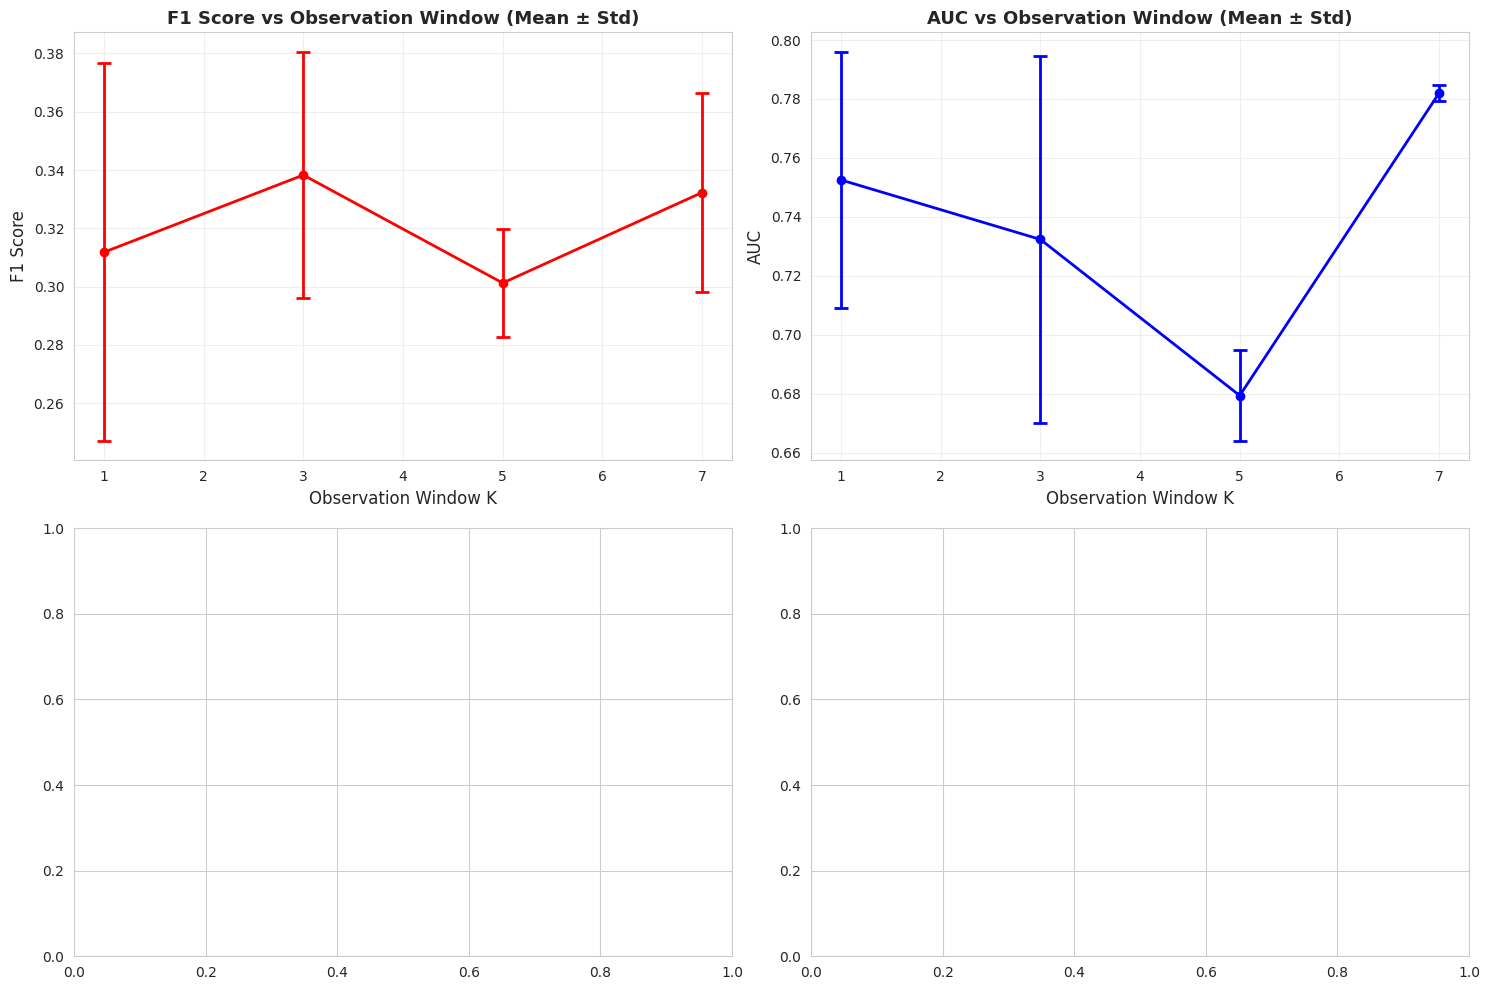

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: F1 Score with error bars
ax = axes[0, 0]
f1_means = summary_df['F1_mean'].values
f1_stds = summary_df['F1_std'].values
ax.errorbar(CONFIG['observation_windows'], f1_means, yerr=f1_stds, 
            marker='o', linewidth=2, capsize=5, capthick=2, color='red')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score vs Observation Window (Mean ± Std)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: AUC with error bars
ax = axes[0, 1]
auc_means = summary_df['AUC_mean'].values
auc_stds = summary_df['AUC_std'].values
ax.errorbar(CONFIG['observation_windows'], auc_means, yerr=auc_stds,
            marker='o', linewidth=2, capsize=5, capthick=2, color='blue')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.set_title('AUC vs Observation Window (Mean ± Std)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# # Plot 3: F1 scores for all seeds (scatter + violin)
# ax = axes[1, 0]
# for K in CONFIG['observation_windows']:
#     k_results = test_results[test_results['K'] == K]
#     ax.scatter([K] * len(k_results), k_results['f1'], alpha=0.6, s=50)
# ax.plot(CONFIG['observation_windows'], f1_means, 'r-', linewidth=2, label='Mean')
# ax.set_xlabel('Observation Window K', fontsize=12)
# ax.set_ylabel('F1 Score', fontsize=12)
# ax.set_title('F1 Score Distribution Across Seeds', fontsize=13, fontweight='bold')
# ax.legend()
# ax.grid(True, alpha=0.3)

# # Plot 4: AUC scores for all seeds
# ax = axes[1, 1]
# for K in CONFIG['observation_windows']:
#     k_results = test_results[test_results['K'] == K]
#     ax.scatter([K] * len(k_results), k_results['auc'], alpha=0.6, s=50)
# ax.plot(CONFIG['observation_windows'], auc_means, 'b-', linewidth=2, label='Mean')
# ax.set_xlabel('Observation Window K', fontsize=12)
# ax.set_ylabel('AUC', fontsize=12)
# ax.set_title('AUC Distribution Across Seeds', fontsize=13, fontweight='bold')
# ax.legend()
# ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Performance Visualization

In [19]:
# Save aggregated summary statistics
summary_df.to_csv(RESULTS_DIR / 'multi_seed_summary_statistics.csv', index=False)
print(f"Saved summary statistics to {RESULTS_DIR / 'multi_seed_summary_statistics.csv'}")

# Save all results (detailed)
all_results_df.to_csv(RESULTS_DIR / 'all_seeds_all_metrics.csv', index=False)
print(f"Saved all metrics to {RESULTS_DIR / 'all_seeds_all_metrics.csv'}")

# Create a README explaining the file structure
readme_content = """# Multi-Seed EvolveGCN Results

This directory contains results from multi-seed training experiments.

## File Structure

### Per-seed predictions (NPZ files):
- `seed{seed}_k{K}_{split}_predictions.npz`
  - Contains detailed predictions for each node
  - Fields:
    - `node_indices`: Node indices in the graph
    - `predictions`: Binary class predictions (0 or 1)
    - `probs_class_0`: Probability of class 0 (licit)
    - `probs_class_1`: Probability of class 1 (illicit)
    - `true_labels`: Ground truth labels
    - `timesteps`: Timestep for each node

### Metrics files:
- `seed{seed}_metrics.csv`: All metrics for a specific seed
- `all_seeds_all_metrics.csv`: Combined metrics from all seeds
- `multi_seed_summary_statistics.csv`: Mean and std statistics across seeds

## Usage Example

```python
import numpy as np
import pandas as pd

# Load predictions for a specific seed/K/split
data = np.load('seed42_k5_test_predictions.npz')
probs = data['probs_class_1']  # Probability of illicit class
labels = data['true_labels']

# Calculate F1 with custom threshold
from sklearn.metrics import f1_score
threshold = 0.3
custom_preds = (probs >= threshold).astype(int)
f1 = f1_score(labels, custom_preds)
print(f"F1 with threshold {threshold}: {f1:.4f}")

# Load summary statistics
summary = pd.read_csv('multi_seed_summary_statistics.csv')
print(summary)
```

## Seeds Used
""" + f"{SEEDS}\n\n"

readme_content += f"""## Observation Windows (K)
{CONFIG['observation_windows']}

## Training Configuration
- Epochs: {EPOCHS}
- Patience: {PATIENCE}
- Hidden dim: {CONFIG['hidden_dim']}
- Learning rate: {CONFIG['learning_rate']}
- Dropout: {CONFIG['dropout']}
"""

with open(RESULTS_DIR / 'README.md', 'w') as f:
    f.write(readme_content)

print(f"Saved README to {RESULTS_DIR / 'README.md'}")
print(f"\nAll results saved to: {RESULTS_DIR}")
print("\nYou can now load the .npz files to recalculate metrics with different thresholds!")

Saved summary statistics to ../../results/evolve_gcn_multi_seed/multi_seed_summary_statistics.csv
Saved all metrics to ../../results/evolve_gcn_multi_seed/all_seeds_all_metrics.csv
Saved README to ../../results/evolve_gcn_multi_seed/README.md

All results saved to: ../../results/evolve_gcn_multi_seed

You can now load the .npz files to recalculate metrics with different thresholds!


## Save Results

In [29]:
import os

os.makedirs('../../results', exist_ok=True)
os.makedirs('../../models', exist_ok=True)

comparison_df.to_csv('../../results/temporal_gcn_results.csv', index=False)
print("Results saved to ../../results/temporal_gcn_results.csv")

for K, model in models.items():
    torch.save(model.state_dict(), f'../../models/temporal_gcn_k{K}.pt')
print(f"Models saved to ../../models/temporal_gcn_k*.pt")

Results saved to ../../results/temporal_gcn_results.csv
Models saved to ../../models/temporal_gcn_k*.pt
